<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/Assignment%204/14_Assignment_4_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#https://www.kaggle.com/code/tilasousa/face-mask-detection-using-keras-cnn

# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import cv2
from scipy.spatial import distance
import glob
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import classification_report , confusion_matrix
from skimage import io
filterwarnings("ignore")

from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import load_img


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow_datasets as tfds
from keras import callbacks
from sklearn.metrics import accuracy_score
from os import listdir
from os.path import isfile, join

In [3]:
## Accuracy and Loss Graph
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

## Validation Report
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

## Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

# defining callback function to avoid overfit
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 6, 
                                        restore_best_weights = True, verbose=1)

# EDA

The path is created for getting data and then I concatened dataframes of mask and without mask.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# pipeline parameter
BATCH_SIZE = 32
IMG_SIZE = (256, 256)
PATH  = '/content/gdrive/My Drive/MSDS 458/Assignment 4 - Final/Data/Face Mask Dataset/'

In [6]:
# train dataset
train_dir = os.path.join(PATH, 'Train')

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True)

Found 10000 files belonging to 2 classes.


In [7]:
# validation dataset
validation_dir = os.path.join(PATH, 'Validation')

validation_ds = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True)

Found 800 files belonging to 2 classes.


In [8]:
# test dataset
test_dir = os.path.join(PATH, 'Test')

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=False)

Found 992 files belonging to 2 classes.


In [9]:
# class names
class_names = train_ds.class_names
print(class_names)

['WithMask', 'WithoutMask']


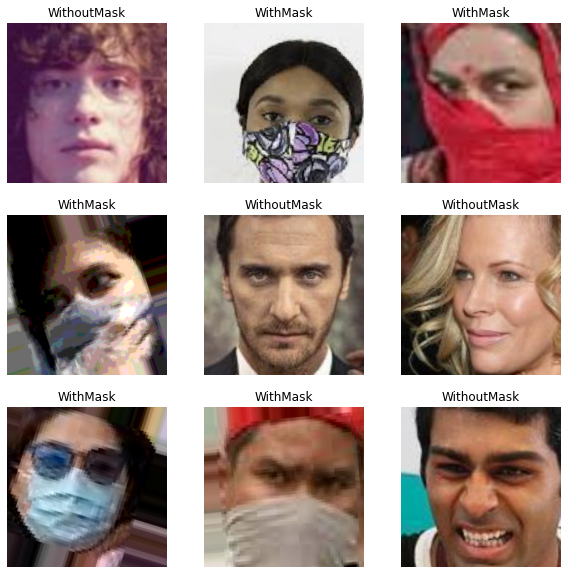

In [10]:
# data visualization
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
# autotune buffer to avoid I/0 block
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [24]:
# defining callback function to avoid overfit
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 2, 
                                        restore_best_weights = True, verbose=1)

In [25]:
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=41,
  callbacks =[earlystopping]
)

Epoch 1/41
313/313 [==============================] - 6s 16ms/step - loss: 0.2156 - accuracy: 0.9176 - val_loss: 0.0789 - val_accuracy: 0.9787
Epoch 2/41
313/313 [==============================] - 5s 15ms/step - loss: 0.0888 - accuracy: 0.9689 - val_loss: 0.0840 - val_accuracy: 0.9688
Epoch 3/41
313/313 [==============================] - 5s 15ms/step - loss: 0.0728 - accuracy: 0.9753 - val_loss: 0.0746 - val_accuracy: 0.9775
Epoch 4/41
313/313 [==============================] - 5s 15ms/step - loss: 0.0594 - accuracy: 0.9813 - val_loss: 0.0585 - val_accuracy: 0.9862
Epoch 5/41
313/313 [==============================] - 5s 15ms/step - loss: 0.0459 - accuracy: 0.9833 - val_loss: 0.0241 - val_accuracy: 0.9912
Epoch 6/41
313/313 [==============================] - 5s 15ms/step - loss: 0.0347 - accuracy: 0.9875 - val_loss: 0.0223 - val_accuracy: 0.9900
Epoch 7/41
313/313 [==============================] - 5s 15ms/step - loss: 0.0240 - accuracy: 0.9924 - val_loss: 0.0406 - val_accuracy: 0.9850

In [26]:
e = model.evaluate(test_ds)

31/31 [==============================] - 1s 20ms/step - loss: 0.0618 - accuracy: 0.9829


In [27]:
test_pred = model.predict(test_ds)
test_pred = np.argmax(test_pred,axis = 1)
test_labels = np.concatenate([y for x, y in test_ds], axis=0) 

31/31 [==============================] - 1s 19ms/step


In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
history_df = pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
3,0.059,0.981,0.059,0.986
4,0.046,0.983,0.024,0.991
5,0.035,0.988,0.022,0.990
6,0.024,0.992,0.041,0.985
7,0.022,0.992,0.025,0.990


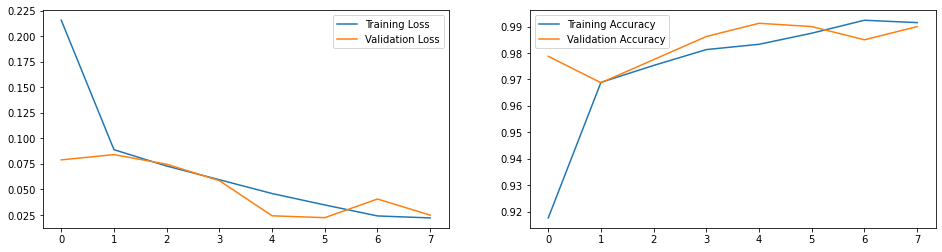

In [30]:
## Loss and acuracy
plot_history(history)

Text(0.5, 1.0, 'Confusion Matrix - Test Set')

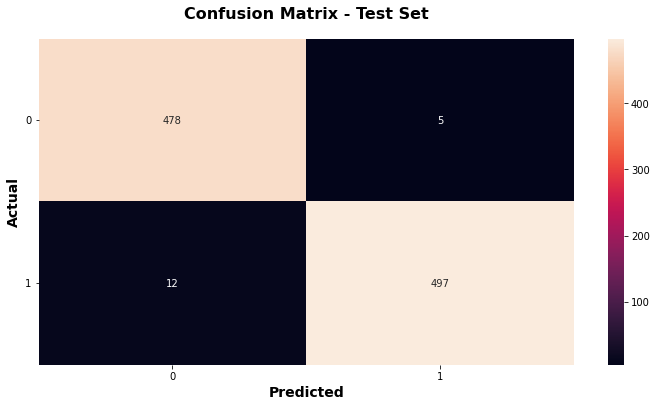

In [31]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels,
    test_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20)

In [32]:
import numpy
from sklearn import metrics

actual15 = test_labels
predicted15 = test_pred

Accuracy = metrics.accuracy_score(actual15, predicted15)
Precision = metrics.precision_score(actual15, predicted15)
Sensitivity_recall = metrics.recall_score(actual15, predicted15)
Specificity = metrics.recall_score(actual15, predicted15, pos_label=0)
F1_score = metrics.f1_score(actual15, predicted15)

#metrics:
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})

{'Accuracy': 0.9828629032258065, 'Precision': 0.9900398406374502, 'Sensitivity_recall': 0.9764243614931237, 'Specificity': 0.989648033126294, 'F1_score': 0.9831849653808111}


In [33]:
# report
labels = ['withMask', 'withoutMask']
print(classification_report(actual15, predicted15, target_names = labels))

              precision    recall  f1-score   support

    withMask       0.98      0.99      0.98       483
 withoutMask       0.99      0.98      0.98       509

    accuracy                           0.98       992
   macro avg       0.98      0.98      0.98       992
weighted avg       0.98      0.98      0.98       992

